In [0]:
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, StringType, IntegerType
from pyspark.sql.functions import *

In [0]:
df=spark.read.load("/FileStore/tables/heart_disease_uci.csv",format="csv",sep=",",header="true",escape='"',inferSchema="true")

In [0]:
df.show(10)

+---+---+------+---------+---------------+--------+----+-----+--------------+------+-----+-------+-----------+---+-----------------+---+
| id|age|   sex|  dataset|             cp|trestbps|chol|  fbs|       restecg|thalch|exang|oldpeak|      slope| ca|             thal|num|
+---+---+------+---------+---------------+--------+----+-----+--------------+------+-----+-------+-----------+---+-----------------+---+
|  1| 63|  Male|Cleveland| typical angina|     145| 233| true|lv hypertrophy|   150|false|    2.3|downsloping|  0|     fixed defect|  0|
|  2| 67|  Male|Cleveland|   asymptomatic|     160| 286|false|lv hypertrophy|   108| true|    1.5|       flat|  3|           normal|  2|
|  3| 67|  Male|Cleveland|   asymptomatic|     120| 229|false|lv hypertrophy|   129| true|    2.6|       flat|  2|reversable defect|  1|
|  4| 37|  Male|Cleveland|    non-anginal|     130| 250|false|        normal|   187|false|    3.5|downsloping|  0|           normal|  0|
|  5| 41|Female|Cleveland|atypical angina

In [0]:
df.count()

Out[4]: 920

In [0]:
df.printSchema()

root
 |-- id: integer (nullable = true)
 |-- age: integer (nullable = true)
 |-- sex: string (nullable = true)
 |-- dataset: string (nullable = true)
 |-- cp: string (nullable = true)
 |-- trestbps: integer (nullable = true)
 |-- chol: integer (nullable = true)
 |-- fbs: boolean (nullable = true)
 |-- restecg: string (nullable = true)
 |-- thalch: integer (nullable = true)
 |-- exang: boolean (nullable = true)
 |-- oldpeak: double (nullable = true)
 |-- slope: string (nullable = true)
 |-- ca: integer (nullable = true)
 |-- thal: string (nullable = true)
 |-- num: integer (nullable = true)



In [0]:
for column in df.columns:
    null_count = df.where(col(column).isNull()).count()
    print(f"{column}: {null_count} null values")

id: 0 null values
age: 0 null values
sex: 0 null values
dataset: 0 null values
cp: 0 null values
trestbps: 59 null values
chol: 30 null values
fbs: 90 null values
restecg: 2 null values
thalch: 55 null values
exang: 55 null values
oldpeak: 62 null values
slope: 309 null values
ca: 611 null values
thal: 486 null values
num: 0 null values


In [0]:
df = df.dropna()

In [0]:
for column in df.columns:
    null_count = df.where(col(column).isNull()).count()
    print(f"{column}: {null_count} null values")

id: 0 null values
age: 0 null values
sex: 0 null values
dataset: 0 null values
cp: 0 null values
trestbps: 0 null values
chol: 0 null values
fbs: 0 null values
restecg: 0 null values
thalch: 0 null values
exang: 0 null values
oldpeak: 0 null values
slope: 0 null values
ca: 0 null values
thal: 0 null values
num: 0 null values


In [0]:
df.createOrReplaceTempView("heart")

In [0]:
%sql
--cinsiyetlere göre hasta olan ve hasta olmayan kişi sayısını getirip bu sayıları baz alarak cinsiyetler özelinde kalp hastası oranını getiren sorgu
SELECT sex, 
       SUM(CASE WHEN num = 0 THEN 1 ELSE 0 END) AS no_heart_disease,
       SUM(CASE WHEN num > 0 THEN 1 ELSE 0 END) AS heart_disease,
       CONCAT(ROUND((SUM(CASE WHEN num > 0 THEN 1 ELSE 0 END) / COUNT(*)) * 100, 2), '%') AS heart_disease_rate
FROM heart
GROUP BY sex


sex,no_heart_disease,heart_disease,heart_disease_rate
Female,71,25,26.04%
Male,89,114,56.16%


In [0]:
%sql
--erkekler için en çok hastalık gorulen 10 yaşı ve o yaştaki hasta sayısını getiren sorgu
SELECT sex, age, COUNT(*) AS heart_disease_count
FROM heart
WHERE num > 0 AND sex = 'Female'
GROUP BY sex, age
ORDER BY COUNT(*) DESC
limit 10


sex,age,heart_disease_count
Female,62,5
Female,63,3
Female,57,2
Female,61,2
Female,58,2
Female,56,2
Female,60,2
Female,55,2
Female,65,1
Female,66,1


Databricks visualization. Run in Databricks to view.

In [0]:
%sql
--kadınlar için en çok hastalık gorulen 10 yaşı ve o yaştaki hasta sayısını getiren sorgu

SELECT sex, age, COUNT(*) AS heart_disease_count
FROM heart
WHERE num > 0 AND sex = 'Male'
GROUP BY sex, age
ORDER BY COUNT(*) DESC
limit 10


sex,age,heart_disease_count
Male,58,10
Male,59,8
Male,57,8
Male,60,7
Male,54,6
Male,67,6
Male,56,5
Male,61,5
Male,64,4
Male,55,3


Databricks visualization. Run in Databricks to view.

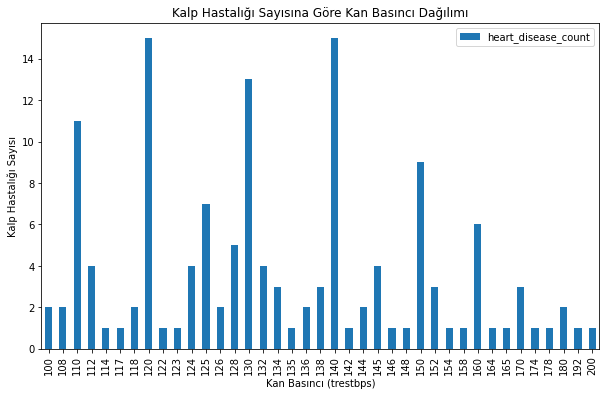

In [0]:
from pyspark.sql.functions import col, count

# Kan basıncına (trestbps) göre kalp hastalığına sahip sayısını analiz etme
heart_disease_count_trestbps = df.where(col("num") > 0) \
    .groupBy("trestbps") \
    .agg(count("*").alias("heart_disease_count")) \
    .orderBy("trestbps", ascending=True) \
    .toPandas()

import matplotlib.pyplot as plt
 
heart_disease_count_trestbps.plot(kind='bar', x='trestbps', y='heart_disease_count', figsize=(10,6))
plt.title('Kalp Hastalığı Sayısına Göre Kan Basıncı Dağılımı')
plt.xlabel('Kan Basıncı (trestbps)')
plt.ylabel('Kalp Hastalığı Sayısı')
plt.show()



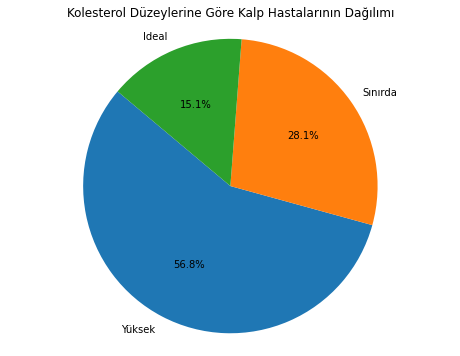

In [0]:
#Kolesterol Düzeylerine Göre Kalp Hastalarının Dağılımı

heart_disease_by_chol=df.withColumn("cholesterol_level",
              when(col("chol") < 200, "Ideal")
              .when((col("chol") >= 200) & (col("chol") <= 239), "Sınırda")
                .otherwise("Yüksek")) \


heart_disease_by_chol=heart_disease_by_chol.where(col("num")>0) \
    .groupBy("cholesterol_level") \
    .agg(count("*").alias("heart_disease_count")) \
    .orderBy("heart_disease_count", ascending=False) \
    .toPandas()
    

plt.figure(figsize=(8, 6))
plt.pie(heart_disease_by_chol['heart_disease_count'], labels=heart_disease_by_chol['cholesterol_level'], autopct='%1.1f%%', startangle=140)
plt.title('Kolesterol Düzeylerine Göre Kalp Hastalarının Dağılımı')
plt.axis('equal')  
plt.show()



    

                                      
                                    
              
                                      

              


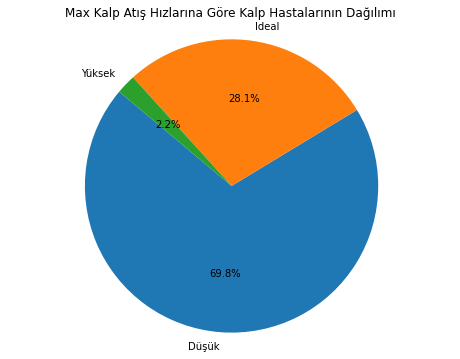

In [0]:
#'Max Kalp Atış Hızlarına Göre Kalp Hastalarının Dağılımı


df_thalch_category = df.withColumn("thalch_category",
                  when(col("thalch") < 153, "Düşük")
                  .when((col("thalch") >= 153) & (col("thalch") <= 180), "Ideal")
                  .when(col("thalch") > 180, "Yüksek")
                  .otherwise("Unknown"))

df_thalch_category = df_thalch_category.where(col("num") > 0) \
    .groupBy("thalch_category") \
    .agg(count("*").alias("heart_disease_count")) \
    .orderBy("heart_disease_count", ascending=False) \
    .toPandas()

plt.figure(figsize=(8, 6))
plt.pie(df_thalch_category['heart_disease_count'], labels=df_thalch_category['thalch_category'], autopct='%1.1f%%', startangle=140)
plt.title('Max Kalp Atış Hızlarına Göre Kalp Hastalarının Dağılımı')
plt.axis('equal')
plt.show()

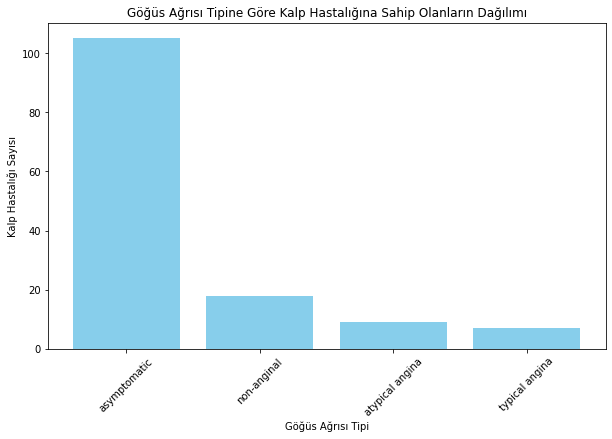

In [0]:
from pyspark.sql import functions as F

# Göğüs ağrısı tipine göre kalp hastalığına sahip olan kişilerin sayısı
df_cp_count = df.where(df.num > 0) \
    .groupBy("cp") \
    .agg(F.count("*").alias("cp_count")) \
    .orderBy("cp_count", ascending=False)


import matplotlib.pyplot as plt
# toPandas
df_pd = df_cp_count.toPandas()

# grafik
plt.figure(figsize=(10, 6))
plt.bar(df_pd['cp'], df_pd['cp_count'], color='skyblue')
plt.xlabel('Göğüs Ağrısı Tipi')
plt.ylabel('Kalp Hastalığı Sayısı')
plt.title('Göğüs Ağrısı Tipine Göre Kalp Hastalığına Sahip Olanların Dağılımı')
plt.xticks(rotation=45)
plt.show()



